In [1]:
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
import pyro.poutine as poutine
import torch
from pyro.infer.mcmc import MCMC, NUTS
import numpy as np
import matplotlib.pyplot as plt
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from scipy import stats
from pyro.contrib import autoguide

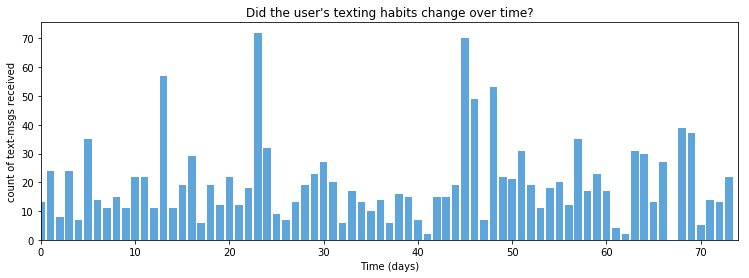

In [2]:
count_data = np.array([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
])
n_count_data = count_data.size
days = np.arange(n_count_data)

  
plt.figure(figsize=(12.5, 4))
plt.bar(days, count_data, color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

In [3]:
days = torch.tensor(days, dtype=torch.float32, device='cpu')

In [202]:
alpha = 1 / count_data.mean()
def model(count_data, device='cpu'):
    lambda_1 = pyro.sample('lambda_1', dist.Exponential(torch.tensor([alpha], device=device)))
    lambda_2 = pyro.sample('lambda_2', dist.Exponential(torch.tensor([alpha], device=device)))
    
    tau = pyro.sample('tau', dist.Uniform(torch.zeros(1, device=device), torch.ones(1, device=device)))
    
    # makes sure gradients can flow through 
    lambda_1_size = (tau * count_data.shape[0] + 1).long()
    lambda_2_size = count_data.shape[0] - lambda_1_size
    lambda_ = torch.cat([lambda_1.expand(lambda_1_size), lambda_2.expand(lambda_2_size)])
    
    with pyro.plate('data', size=count_data.shape[0]):
        pyro.sample('obs', dist.Poisson(lambda_), obs=count_data)

# def conditioned_model(model, count_data):
#     return poutine.condition(model,  data={"obs": count_data})(count_data)
    
model(torch.tensor(count_data, device='cuda'))

In [222]:
nuts_kernel = NUTS(conditioned_model, jit_compile=True, max_tree_depth=7)
posterior = MCMC(nuts_kernel,
                num_samples=500,
                warmup_steps=100).run(model, torch.tensor(count_data, dtype=torch.float32, device='cpu'))

Warmup:   0%|          | 0/600 [00:00<?, ?it/s]/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  after removing the cwd from sys.path.
/opt/miniconda3/lib/python3.7/site-packages/pyro/poutine/subsample_messenger.py:58: Tra

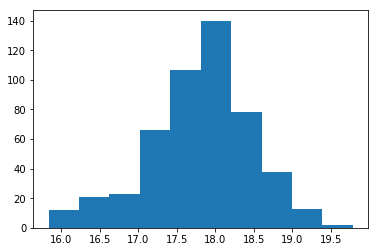

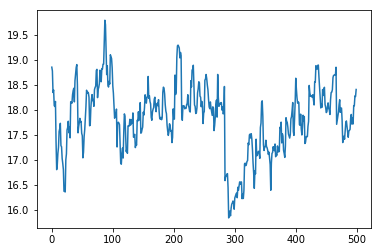

In [234]:
m = posterior.marginal(['lambda_1', 'lambda_2', 'tau'])
plt.hist(m.support()['lambda_1'].numpy().flatten())
plt.show()
plt.plot(m.support()['lambda_1'].numpy().flatten())


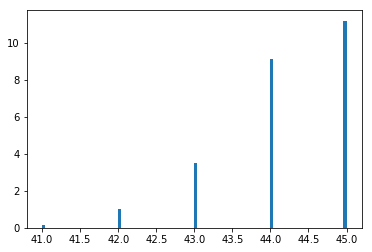

In [235]:
plt.hist(np.array(m.support()['tau'].numpy().flatten() * count_data.shape[0] + 1, dtype=int), density=1, bins=100)
plt.show()